# UCLA Scandinavian DH Seminar, November 2017

Notebook to perform text similarity calculation and clustering for seminar hackathon.

Initial work by Matthew Wilkens, November 2017.

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from   mpl_toolkits.mplot3d import Axes3D
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from   collections import defaultdict
import csv
import itertools
import numpy as np
import operator
import pandas as pd
import random
from   sklearn.cluster import KMeans, DBSCAN
from   sklearn.decomposition import PCA
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.metrics import silhouette_samples, silhouette_score
from   sklearn.metrics.pairwise import pairwise_distances
from   sklearn.preprocessing import StandardScaler

In [ ]:
# Additional imports if processing full input texts rather than loading derived data
from   glob import glob
import shutil
from   IPython.display import display

In [32]:
%matplotlib inline

corpus_name = 'ADL'
figDir     = 'figures'
resultsDir = 'results'
dataDir    = os.path.join('..', '..', corpus_name)
metadataFile = os.path.join(dataDir, 'metadata', 'metadata_adl.csv')
corpusDir = os.path.join(dataDir, 'plain')

sns.set()
sns.set_context('notebook')
plt.rc('figure', figsize=(12, 8))

In [47]:
metadata = pd.read_csv(metadataFile, index_col='file_id')

In [48]:
metadata.head()

,author,title,volume,birth,death
file_id,,,,,
grundtvig11val_workid118888,N.F.S. Grundtvig,Jeg som et barn mig glæde vil,SAMLET UDGAVE,1783,1872
stuckenberg02_workid77235,Viggo Stuckenberg,For vinden danser,SAMLEDE VÆRKER,1863,1905
hauch03val_workid83908,Carsten Hauch,Sang af bajazet,UDVALGTE SKRIFTER III,1790,1872
plough01_workid56672,Carl Ploug,Vers paa bellmanske melodier,SAMLEDE DIGTE,1813,1894
hjort_02_workid54087,Knud Hjortø,Kraft,KRAFT,1869,1931


In [49]:
metadata.describe()

,birth,death
count,8787.000000,8787.000000
mean,1785.979060,1849.617048
std,89.231021,87.095092
min,0.000000,0.000000
25%,1764.000000,1826.000000
50%,1800.000000,1872.000000
75%,1863.000000,1914.000000
max,1912.000000,1938.000000


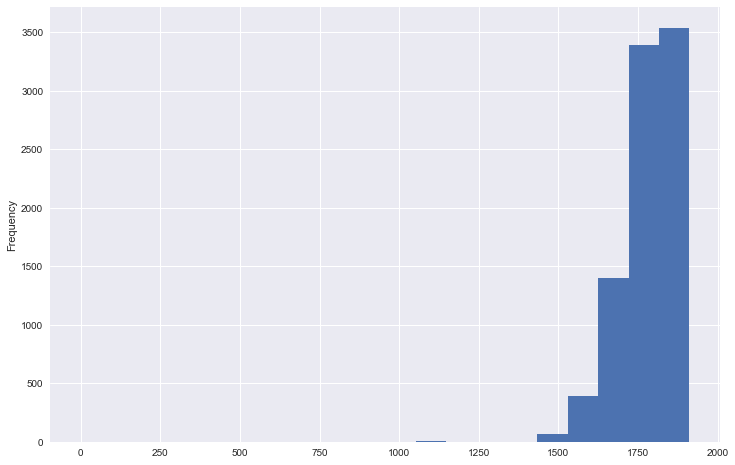

In [11]:
fig = metadata.birth.plot.hist(bins=20)

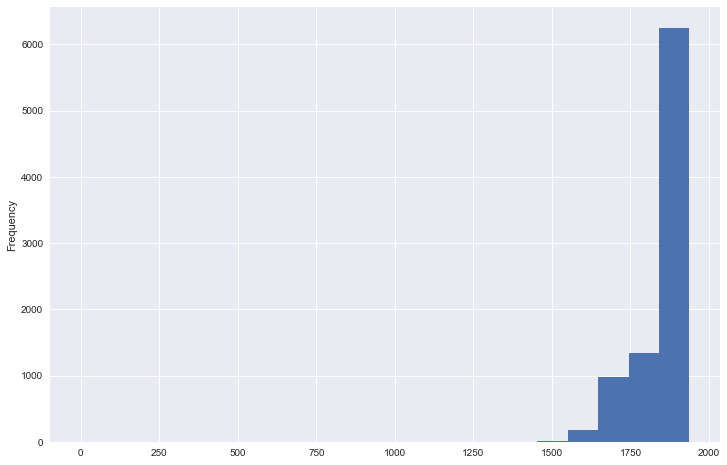

In [12]:
fig = metadata.death.plot.hist(bins=20)

In [50]:
metadata[metadata.death == 0]

,author,title,volume,birth,death
file_id,,,,,
larsenk_09_workid54089,kapitel,Lægemidler,DOMMENS DAG,0,0


In [65]:
md = metadata[metadata.birth != 0]

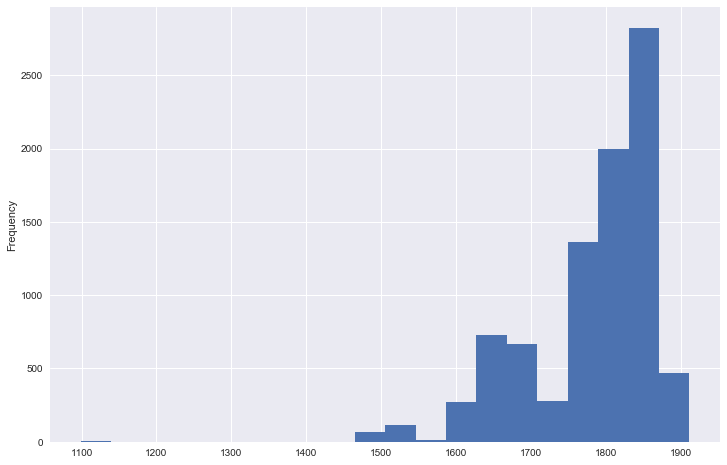

In [66]:
md.birth.plot.hist(bins=20)

In [67]:
md.describe()

,birth,death
count,8786.000000,8786.000000
mean,1786.182336,1849.827567
std,87.177709,84.834845
min,1099.000000,1208.000000
25%,1764.000000,1826.000000
50%,1800.000000,1872.000000
75%,1863.000000,1914.000000
max,1912.000000,1938.000000


In [68]:
md.author.nunique()

75

In [69]:
md.volume.nunique()

299

In [33]:
corpus = PlaintextCorpusReader(corpusDir, '.*\.txt')

In [39]:
corpus.fileids()[:5]

['Lars_workid54234.txt',
 'Lars_workid60226.txt',
 'Lars_workid63000.txt',
 'aakjaer01val_workid100074.txt',
 'aakjaer01val_workid100247.txt']

In [40]:
md[md.file_id == 'Lars_workid54234']

,file_id,author,title,volume,birth,death
3231,Lars_workid54234,Karl Larsen,Udenfor rangklasserne,Københavnerfortællinger,1860,1931


In [41]:
len(corpus.words('Lars_workid54234.txt'))

35021

In [70]:
wordcounts = {}
for fileid in corpus.fileids():
    wordcounts[fileid.strip('.txt')] = len(corpus.words(fileid))
md = md.join(pd.Series(wordcounts, name='wordcount'))

In [71]:
md.head()

,author,title,volume,birth,death,wordcount
file_id,,,,,,
grundtvig11val_workid118888,N.F.S. Grundtvig,Jeg som et barn mig glæde vil,SAMLET UDGAVE,1783,1872,340.0
stuckenberg02_workid77235,Viggo Stuckenberg,For vinden danser,SAMLEDE VÆRKER,1863,1905,131.0
hauch03val_workid83908,Carsten Hauch,Sang af bajazet,UDVALGTE SKRIFTER III,1790,1872,360.0
plough01_workid56672,Carl Ploug,Vers paa bellmanske melodier,SAMLEDE DIGTE,1813,1894,333.0
hjort_02_workid54087,Knud Hjortø,Kraft,KRAFT,1869,1931,66532.0


In [85]:
md[md.wordcount.isnull()]

,author,title,volume,birth,death,wordcount
file_id,,,,,,
topsoe01_workid61481,Vilhelm Topsøe,I september,UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN
topsoe01_workid78246,Vilhelm Topsøe,Liebe og krabbe,UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN
topsoe01_workid75966,Vilhelm Topsøe,Andræ,UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN
topsoe01_workid63616,Vilhelm Topsøe,Skoven ved middagstid.,UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN
tycho-04-uraniatitani_nodecls_140049346759136,Tycho Brahe,NaN,Urania Titani,1546,1601,NaN
topsoe01_workid67727,Vilhelm Topsøe,Slagne folk (1882),UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN
tycho-08-tvillingebror_nodecls_140120597757760,Tycho Brahe,NaN,Gravskrift over dødfødt tvillingebror,1546,1601,NaN
topsoe01_workid76695,Vilhelm Topsøe,Hall,UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN
topsoe01_workid74869,Vilhelm Topsøe,Politiske portrætstudier (1878),UDVALGTE SKRIFTER FØRSTE BIND,1840,1881,NaN


In [78]:
md.describe()

,birth,death,wordcount
count,8786.000000,8786.000000,8756.000000
mean,1786.182336,1849.827567,3519.952490
std,87.177709,84.834845,15481.301496
min,1099.000000,1208.000000,0.000000
25%,1764.000000,1826.000000,140.000000
50%,1800.000000,1872.000000,294.000000
75%,1863.000000,1914.000000,768.250000
max,1912.000000,1938.000000,389825.000000


In [86]:
md[md.wordcount > 100000].sort_values('wordcount', ascending=False)

,author,title,volume,birth,death,wordcount
file_id,,,,,,
saxoval_workid54112,Saxo,Fra piazza del popolo · i,Saxos Danmarkshistorie,1132,1208,389825.0
bergsoev01ny_workid54112,Vilhelm Bergsøe,Fra piazza del popolo · i,"Fra Piazza del Popolo · I-III<lb xml:id=""idm13...",1835,1911,298784.0
grundtvig06val_workid54333,N.F.S. Grundtvig,Hovedstrømninger. reaktionen i frankrig (1874),UDVALGTE SKRIFTER,1783,1872,251453.0
ingemann02_workid54477,B.S. Ingemann,Valdemar seier,Valdemar Seier,1789,1862,215963.0
kierkegaard03val_workid54108,Søren Kierkegaard,'at være eller ikke være.',Dagbøger i udvalg 1834-1846,1813,1855,212275.0
holberg13val_workid54110,Ludvig Holberg,Moralske tanker (dk),Moralske Tanker,1684,1754,189374.0
kidde04ny_workid54108,Harald Kidde,'at være eller ikke være.',Jærnet,1878,1918,187984.0
heibfr01_workid54096,Johanne Luise Heiberg,"Et liv genoplevet i erindringen, bind i 1812-42",Et liv genoplevet i erindringen BIND I 1812-42,1812,1890,186184.0
schandorph04_workid54192,Sophus Schandorph,Thomas fris's historie (1881),ROMANER ANDET BIND,1836,1901,185545.0


In [87]:
md = md[md.wordcount > 100]

In [88]:
md.describe()

,birth,death,wordcount
count,7384.000000,7384.000000,7384.000000
mean,1782.849269,1848.051598,4163.144095
std,85.521337,83.992272,16780.005132
min,1099.000000,1208.000000,101.000000
25%,1743.000000,1816.500000,202.000000
50%,1800.000000,1872.000000,381.000000
75%,1858.000000,1908.000000,961.000000
max,1912.000000,1938.000000,389825.000000


In [89]:
md[md.wordcount.isnull()]

,author,title,volume,birth,death,wordcount
file_id,,,,,,


In [91]:
md.wordcount = md.wordcount.astype(int)

In [100]:
md[md.index.isin(['saxoval_workid54112'])]

,author,title,volume,birth,death,wordcount
file_id,,,,,,
saxoval_workid54112,Saxo,Fra piazza del popolo · i,Saxos Danmarkshistorie,1132,1208,389825


In [101]:
md[md.wordcount > 10000].wordcount.count()

568

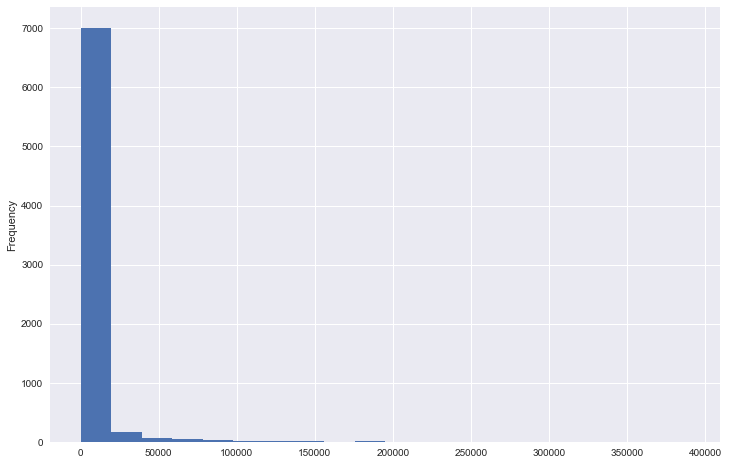

In [103]:
md.wordcount.plot.hist(bins=20)

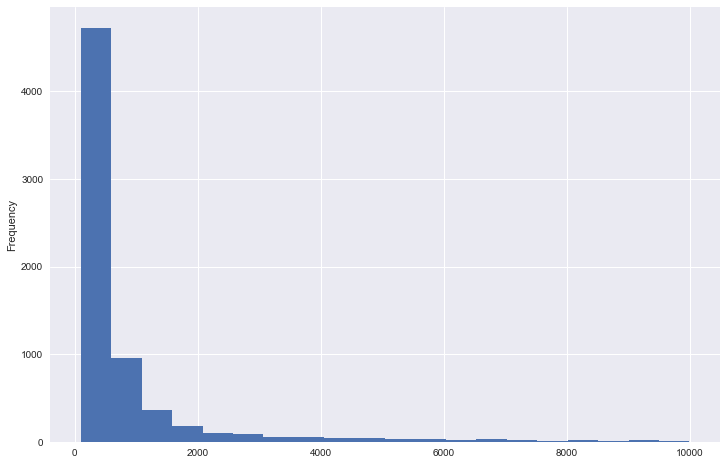

In [106]:
md[md.wordcount < 10000].wordcount.plot.hist(bins=20)

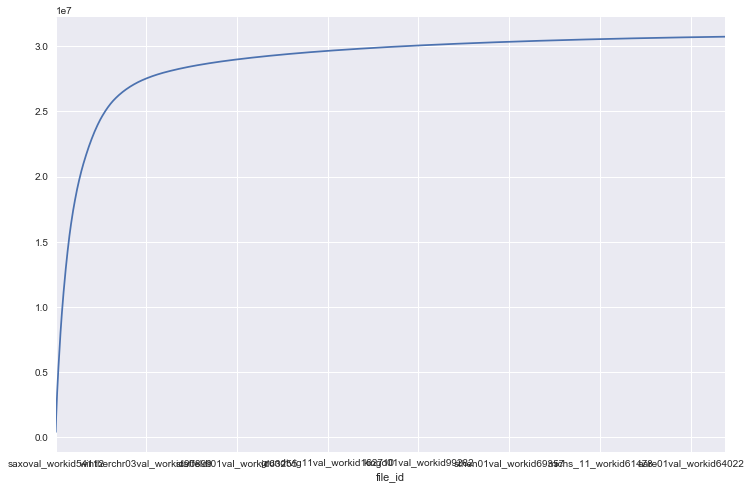

In [112]:
md.wordcount.sort_values(ascending=False).cumsum().plot()

In [117]:
print("Total volumes with wordcount > 100 =", md.wordcount.count(), 
      "containing", md.wordcount.sum(), "words")
print("Total volumes with 100 < wordcount < 10,000 = ", md[md.wordcount < 10000].wordcount.count(), 
      "containing", md[md.wordcount < 10000].wordcount.sum(), "words")

Total volumes with wordcount > 100 = 7384 containing 30740656 words
Total volumes with 100 < wordcount < 10,000 =  6816 containing 5503262 words


Consider throwing out long documents (over 10k words?), since they're likely very different from most in the corpus. But know that that will throw away most of the text (31M -> 5.5M words). Something to examine on site.